<a href="https://colab.research.google.com/github/Benylaode/CNN_PART1/blob/main/Percobaan%2C_Alexnet%2C_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
from tensorflow.keras import models, layers
from datasets import load_dataset, DatasetDict, Image, Dataset
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
from google.colab import drive

import numpy as np
import random
import os


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Path dataset dari Google Drive (sesuaikan dengan struktur folder di Google Drive)
dataset_dir = '/content/drive/MyDrive/rps-cv-images/'  # Sesuaikan path

# Mengambil semua folder dalam dataset
class_names = os.listdir(dataset_dir)

# Membuat list untuk menyimpan data dan label
data = []
labels = []

# Mengumpulkan data gambar dan labelnya
for label in class_names:
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):  # Pastikan ini adalah direktori
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            data.append({'image': img_path, 'label': label})

# Mengonversi ke DatasetDict
ds = DatasetDict({
    'train': Dataset.from_list(data),  # Menggunakan semua data untuk train
    'validation': Dataset.from_list(data)  # Menggunakan semua data untuk validation (ubah jika perlu)
})

# Cek jumlah data
print(f'Number of training rows: {len(ds["train"])}')
print(f'Number of validation rows: {len(ds["validation"])}')



Mounted at /content/drive
Number of training rows: 2188
Number of validation rows: 2188


In [4]:
class BaseModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_model(self):
        raise NotImplementedError("Subclasses should implement this method")

    def compile_model(self, model):
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    def fit_model(self, model, train_data, train_labels, epochs=10, batch_size=32):
        model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size)

class AlexNet(BaseModel):

    def build_model(self):
        model = models.Sequential()

        # 1st Conv Layer
        model.add(layers.Conv2D(96, (11, 11), strides=4, activation='relu',
                                input_shape=self.input_shape))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((3, 3), strides=2))

        # 2nd Conv Layer
        model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((3, 3), strides=2))

        # 3rd Conv Layer
        model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

        # 4th Conv Layer
        model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

        # 5th Conv Layer
        model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((3, 3), strides=2))

        # Flattening
        model.add(layers.Flatten())

        # Fully Connected Layers
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        return model

class VGG16(BaseModel):

    def build_model(self):
        model = models.Sequential()

        # Block 1
        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                input_shape=self.input_shape))
        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Block 2
        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Block 3
        model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Block 4
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Block 5
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

        # Flattening
        model.add(layers.Flatten())

        # Fully Connected Layers
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        return model

import numpy as np

def avg_pooling_rgb(image, pool_size=2):
    img_height, img_width, num_channels = image.shape
    out_height = img_height // pool_size
    out_width = img_width // pool_size

    pooled_image = np.zeros((out_height, out_width, num_channels))

    for c in range(num_channels):
        for i in range(0, out_height * pool_size, pool_size):
            for j in range(0, out_width * pool_size, pool_size):
                pooled_image[i // pool_size, j // pool_size, c] = np.mean(image[i:i + pool_size, j:j + pool_size, c])

    return pooled_image


In [5]:
# def display_sample_images(dataset, n_samples=5):
#     plt.figure(figsize=(10, 10))
#     for i, sample in enumerate(dataset["train"].shuffle(seed=42).select(range(n_samples))):
#         img_path = sample['image']  # Mengambil path gambar
#         img = Image.open(img_path).convert('RGB')  # Memuat gambar menggunakan PIL
#         img = np.array(img)  # Mengonversi ke numpy array

#         plt.subplot(1, n_samples, i + 1)
#         plt.imshow(img)
#         plt.axis("off")
#     plt.show()

# display_sample_images(ds)


# classes = ds['train'].features['label'].names
# num_classes = len(classes)
# print(f"Total jumlah kelas: {num_classes}")
# print(f"Nama kelas: {classes}")

# label_distribution = ds['train'].features['label']
# print(f"Distribusi gambar per kelas: {label_distribution}")

# a = random.randint(1, len(ds["train"]))

# sample_img = np.array(ds['train'][a]['image'])
# plt.imshow(sample_img)
# plt.axis('off')
# plt.show()
# print(f"Ukuran gambar (Tinggi, Lebar, Channel): {sample_img.shape}")

# plt.hist(sample_img.ravel(), bins=256, color='orange', alpha=0.7)
# plt.xlabel('Pixel Value')
# plt.ylabel('Frequency')
# plt.title('Histogram Nilai Piksel untuk Gambar Contoh')
# plt.show()

# print(f"Mean nilai piksel: {np.mean(sample_img)}")
# print(f"Standar deviasi nilai piksel: {np.std(sample_img)}")

In [5]:
# Cek isi direktori
os.listdir(dataset_dir)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_labels_one_hot = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

test_labels_one_hot = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes_train = len(train_labels_one_hot.class_indices)
num_classes_test = len(test_labels_one_hot.class_indices)

print(f"Jumlah kelas train: {num_classes_train}")
print(f"Jumlah kelas test: {num_classes_test}")


Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Jumlah kelas train: 3
Jumlah kelas test: 3


In [ ]:
n = sum(1 for i in train_images for a in test_images if np.array_equal(i, a))
print(n)


In [6]:
input_shape = (224, 224, 3)

alexnet = AlexNet(input_shape=input_shape, num_classes=num_classes_train)
model1 = alexnet.build_model()
alexnet.compile_model(model1)

vgg16 = VGG16(input_shape=input_shape, num_classes=num_classes_train)
model2 = vgg16.build_model()
vgg16.compile_model(model2)

history_alexnet = model1.fit(train_labels_one_hot,
                             validation_data=test_labels_one_hot,
                             epochs=10)

history_vggnet = model2.fit(train_labels_one_hot,
                            validation_data=test_labels_one_hot,
                            epochs=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 764s 12s/step - accuracy: 0.3347 - loss: 4.3016 - val_accuracy: 0.3432 - val_loss: 1.0988
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 54s 220ms/step - accuracy: 0.3412 - loss: 1.0984 - val_accuracy: 0.3432 - val_loss: 1.0985
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.3379 - loss: 1.0985 - val_accuracy: 0.3432 - val_loss: 1.0984
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.3451 - loss: 1.0983 - val_accuracy: 0.3432 - val_loss: 1.0984
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.3463 - loss: 1.0989 - val_accuracy: 0.3432 - val_loss: 1.0984
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.3541 - loss: 1.0986 - val_accuracy: 0.3432 - val_loss: 1.0984
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.3666 - loss: 1.0976 - val_accuracy: 0.3432 - val_loss: 1.0984
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.3238 - loss: 1.0990 - val_accuracy: 0.3432

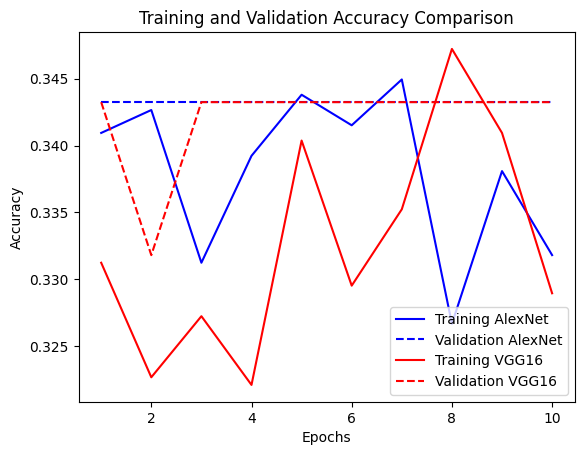

In [7]:
import matplotlib.pyplot as plt

def plot_accuracy(history_alexnet, history_vggnet):
    acc_alexnet = history_alexnet.history['accuracy']
    val_acc_alexnet = history_alexnet.history['val_accuracy']

    acc_vggnet = history_vggnet.history['accuracy']
    val_acc_vggnet = history_vggnet.history['val_accuracy']

    epochs = range(1, len(acc_alexnet) + 1)


    plt.plot(epochs, acc_alexnet, 'b', label='Training AlexNet')
    plt.plot(epochs, val_acc_alexnet, 'b--', label='Validation AlexNet')

    plt.plot(epochs, acc_vggnet, 'r', label='Training VGG16')
    plt.plot(epochs, val_acc_vggnet, 'r--', label='Validation VGG16')

    plt.title('Training and Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_accuracy(history_alexnet, history_vggnet)
